<a href="https://colab.research.google.com/github/subratamondal1/transformers-for-natural-language-processing/blob/main/02_1_Fine_Tuning_Pretrained_Model_on_Any_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Pretrained Model on Any Data.ipynb

## Load Libraries

In [1]:
! pip install transformers torch torchinfo transformers[torch] datasets opendatasets -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torchinfo import summary
import opendatasets as od

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, load_metric

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Load Data

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/tango911/airline-sentiment-tweets'
od.download(dataset_url)

Skipping, found downloaded files in "./airline-sentiment-tweets" (use force=True to force download)


In [6]:
data = pd.read_csv("/content/airline-sentiment-tweets/train.csv")

print(f"Shape: {data.shape}")
data.head()

Shape: (3339, 12)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,Tr_tweet_1,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0.0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,Tr_tweet_2,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0.0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,Tr_tweet_3,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0.0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,Tr_tweet_4,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0.0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,Tr_tweet_5,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0.0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


* There are 12 features but we need only two features `text, airline_sentiment`

In [7]:
data = data[["text", "airline_sentiment"]]

print(f"Shape: {data.shape}")
data.head()

Shape: (3339, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [8]:
print(data.isnull().sum())

data.dropna(inplace = True)

print(data.isnull().sum())

text                 1
airline_sentiment    0
dtype: int64
text                 0
airline_sentiment    0
dtype: int64


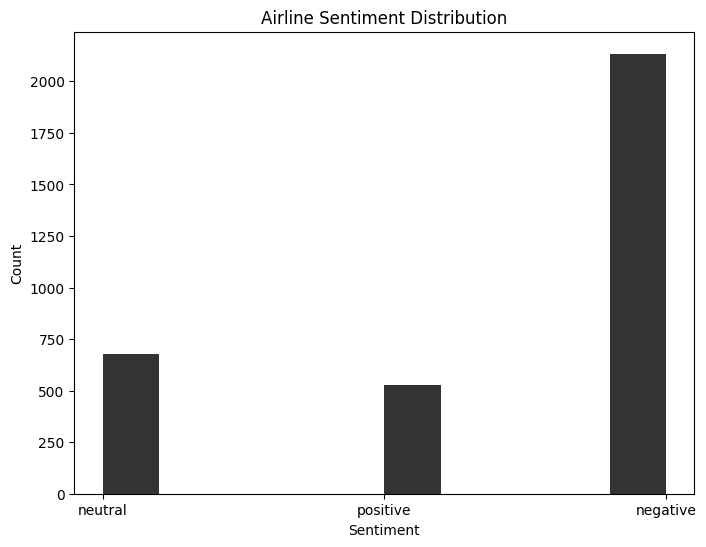

In [9]:
# Let's see the histogram (distribution) of the target feature.
data["airline_sentiment"].hist(color='black', grid = False, alpha=0.8, figsize=(8, 6))
plt.title('Airline Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

* The **target feature** `airline_sentiment` is **imbalanced**, that is the there are more no. of negative samples (rows) than neutral and positive.

In [10]:
# Map postive to 1, negative to 0 and neutral to 2 into target feature
data["target"] = data["airline_sentiment"].map({
    "negative" : 0,
    "positive" : 1,
    "neutral"  : 2
}) # Conversion is Necessary to feed this into Neural Network

data.head()

,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0


## Make Custom data compatible to `datasets`
* The name of the target feature must be `label` to use the `load_dataset` from `datasets` library.
* And save the data in `.csv` format.

In [11]:
data[["text", "target"]].to_csv(
    path_or_buf = "data.csv",
    header = ["sentence", "label"],
    index = False
)

In [12]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@virginamerica Well, I didn't…but NOW I DO! :-D",1


In [13]:
# Loading data as Hugging Face dataset
raw_data = load_dataset(
    path = "csv",
    data_files = "data.csv" # they can also be urls
)

print(raw_data)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3338
    })
})


In [14]:
# # if you have multiple files
# raw_data = load_dataset(
#     path = "csv",
#     data_files = ["data1.csv", "data2.csv"] # they can also be urls
# )

# # if you already have train test split
# raw_data = load_dataset(
#     path = "csv",
#     data_files = {
#         "train" : ["data1.csv", "data2.csv"], # they can also be urls
#         "test"  : ["data3.csv"]               # they can also be urls
#     }
# )

In [15]:
raw_data["train"].to_pandas()

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
...,...,...
3333,@united you have yourselves to blame for givin...,0
3334,@united idea: if u don't want us to be frustra...,0
3335,@united I will be patient in my luxurious midd...,0
3336,@united I will be patient as your agent explai...,0


## Train Test Split

In [16]:
# Split the dataset into train test split
splitted_data = raw_data["train"].train_test_split(
    test_size = 0.3,
    seed = 44
)

print(splitted_data)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2336
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1002
    })
})


## Model & Tokenizer

### Tokenizer

In [17]:
checkpoint = "distilbert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path = checkpoint
)

print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [18]:
def process_data(batch):
  # Tokenization will be applied on each data of the feature "sentence"
  return tokenizer(batch['sentence'], truncation = True) # No padding, it's handled by the model itself


tokenized_dataset = splitted_data.map(
    process_data,
    batched = True
  )

print(tokenized_dataset)

Map:   0%|          | 0/2336 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2336
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1002
    })
})


In [19]:
tokenized_dataset["train"].to_pandas()

,sentence,label,input_ids,attention_mask
0,@united DM sent. Thanks.,1,"[101, 137, 10280, 141, 2107, 1850, 119, 5749, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,.@united I wouldn't describe feces sprinkled i...,0,"[101, 119, 137, 10280, 146, 2010, 112, 189, 55...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,@united So excited I was put on an earlier fli...,1,"[101, 137, 10280, 1573, 7215, 146, 1108, 1508,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Really? 9+hours???? @united: @JenniferWalshPR ...,0,"[101, 8762, 136, 130, 116, 2005, 136, 136, 136...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,@united I'm desperately trying to understand h...,0,"[101, 137, 10280, 146, 112, 182, 9600, 1774, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
2331,@united You cause me to miss my flight telling...,0,"[101, 137, 10280, 1192, 2612, 1143, 1106, 5529...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2332,@united can you ask your guys with flight 1146...,0,"[101, 137, 10280, 1169, 1128, 2367, 1240, 3713...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2333,@united I would have made it if you hadn't alr...,0,"[101, 137, 10280, 146, 1156, 1138, 1189, 1122,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2334,@united #unitedairlines so is it 6:20 pm or 12...,0,"[101, 137, 10280, 108, 10280, 8341, 10443, 117...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### Model

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = checkpoint
)

summary(model)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 65,783,042
Trainable params: 65,783,042
Non-trainable params: 0

In [21]:
training_args = TrainingArguments(
    output_dir = "training_dir",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64
)

print(training_args)

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_length=False,
half_precision_backend=

In [25]:
def compute_metrics(logits_and_lables):
  logits, labels = logits_and_lables
  predictions = np.argmax(logits, axis = -1)
  accuracy = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = "macro")

  return {
      "accuracy" : accuracy,
      "f1_score" : f1
  }

# Creating custom compute metrics because the Trainer wants them in different format
def compute_metrics(logits_and_labels:tuple):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis = -1)
  return metric.compute(
      predictions = predictions,
      references = labels
  )


trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

print(trainer)

RuntimeError: ignored

In [23]:
# Let's train
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


RuntimeError: ignored